# Interactive train and test audio samples limited in length

## Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
!rm -rf runs

9842 chunks


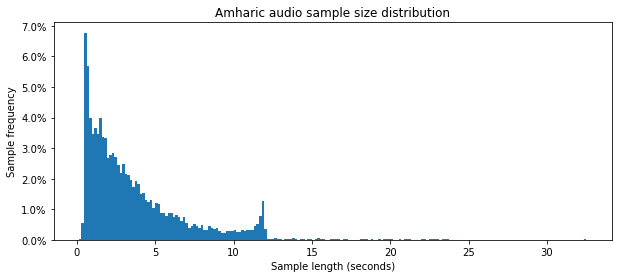

9756 samples up to 12.099999999999994s, so 86 rejected


In [3]:
import sys
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')

import os
os.environ['IN_JUPYTER']='True'

%matplotlib inline
import matplotlib.pylab as plt



from audio_chunk_size import audio_chunk_size
from glob import glob
from models.asr.transformer import Transformer, Encoder, Decoder
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast
from utils import constant
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from utils.functions import save_model, load_model, init_transformer_model, init_optimizer
from utils.lstm_utils import LM
from utils.metrics import calculate_metrics, calculate_cer, calculate_wer, calculate_cer_en_zh
from utils.optimizer import NoamOpt
import json, logging, math, os, random, time, torch, sys, random
import numpy as np
import torch.nn as nn
from Trainer import Trainer

language='amharic'
stage='NIST'
chunks = list(sorted(glob(f'{stage}/openasr20_{language}/build/transcription_split/*.txt')))

n_samples=len(chunks)
print(n_samples, 'chunks')
size_chunks=list(sorted([audio_chunk_size(fn) for fn in chunks]))

from matplotlib.ticker import PercentFormatter
data = [x for x,y in size_chunks]
plt.figure(figsize=(10,4))
plt.hist(data, weights=np.ones(len(data)) / len(data), bins=200)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Sample length (seconds)')
plt.ylabel('Sample frequency')
plt.title('Amharic audio sample size distribution')
plt.savefig(f'analysis/{language}/{language}_audio_sample_size.png')
plt.show()

H=[x for x in size_chunks if x[0] <= 12.12]
L=[]
for length, text in H:
    audio=text.replace('transcription','audio').replace('txt', 'wav')
    L.append(f'{audio},{text}')

n_samples

print(f'{len(L)} samples up to {length}s, so {n_samples-len(L)} rejected')

manifest_file_path=f'analysis/{language}/size_1.csv'
with open(manifest_file_path,'w') as f:
    f.write('\n'.join(L))

model_dir=f'save/{language}_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4'

args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = f'analysis/{language}/{language}_characters.json'
args.lr = 1e-4
args.name = f'{language}_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4'
args.save_folder = f'save'
args.epochs = 1000
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=8000
args.train_manifest_list = [manifest_file_path]
args.continue_from=f'{model_dir}/best_model.th'

args.augment=True

audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))

# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

if constant.args.continue_from:
        model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(
            constant.args.continue_from)
        start_epoch = epoch  # index starts from zero
        verbose = constant.args.verbose
else:
    model = init_transformer_model(constant.args, label2id, id2label)
    opt = init_optimizer(constant.args, model, "noam")

start_epoch = epoch
metrics = None
loaded_args = None
verbose = True

constant.USE_CUDA=True

train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=args.train_manifest_list, 
                                label2id=label2id, normalize=True, augment=args.augment)

loss_type = args.loss
model = model.cuda(0)
num_epochs = start_epoch + 2000

## Training

In [4]:
args.batch_size = 9
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

trainer = Trainer()

In [5]:
trainer.train(model, train_loader, train_sampler, opt, loss_type, start_epoch, num_epochs, label2id, id2label, metrics)

(Epoch 15165) TRAIN LOSS:1.4768 CER:54.88% LR:0.0000198: 100%|██████████| 1084/1084 [03:46<00:00,  4.78it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15165.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15166) TRAIN LOSS:1.4737 CER:54.78% LR:0.0000198: 100%|██████████| 1084/1084 [03:46<00:00,  4.79it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15166.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15167) TRAIN LOSS:1.4714 CER:54.63% LR:0.0000198: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15167.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15168) TRAIN LOSS:1.4692 CER:54.61% LR:0.0000198: 100%|██████████| 1084/1084 [03:45<00:00,  4.80it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15168.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15169) TRAIN LOSS:1.4688 CER:54.65% LR:0.0000198: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15169.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15170) TRAIN LOSS:1.4658 CER:54.53% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15170.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15171) TRAIN LOSS:1.4634 CER:54.51% LR:0.0000197: 100%|██████████| 1084/1084 [03:44<00:00,  4.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15171.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15172) TRAIN LOSS:1.4661 CER:54.56% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15172.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15173) TRAIN LOSS:1.4579 CER:54.38% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15173.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15174) TRAIN LOSS:1.4563 CER:54.30% LR:0.0000197: 100%|██████████| 1084/1084 [03:44<00:00,  4.84it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15174.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15175) TRAIN LOSS:1.4550 CER:54.25% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15175.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15176) TRAIN LOSS:1.4572 CER:54.31% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15176.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15177) TRAIN LOSS:1.4516 CER:54.14% LR:0.0000197: 100%|██████████| 1084/1084 [03:42<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15177.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15178) TRAIN LOSS:1.4505 CER:54.10% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15178.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15179) TRAIN LOSS:1.4497 CER:54.17% LR:0.0000197: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15179.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15180) TRAIN LOSS:1.4490 CER:54.03% LR:0.0000196: 100%|██████████| 1084/1084 [03:42<00:00,  4.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15180.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15181) TRAIN LOSS:1.4420 CER:54.04% LR:0.0000196: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15181.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15182) TRAIN LOSS:1.4419 CER:53.94% LR:0.0000196: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15182.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15183) TRAIN LOSS:1.4406 CER:53.96% LR:0.0000196: 100%|██████████| 1084/1084 [03:42<00:00,  4.87it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15183.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15184) TRAIN LOSS:1.4375 CER:53.76% LR:0.0000196: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15184.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15185) TRAIN LOSS:1.4359 CER:53.89% LR:0.0000196: 100%|██████████| 1084/1084 [03:43<00:00,  4.85it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15185.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15186) TRAIN LOSS:1.4337 CER:53.69% LR:0.0000196: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15186.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15187) TRAIN LOSS:1.4319 CER:53.66% LR:0.0000196: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15187.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15188) TRAIN LOSS:1.4327 CER:53.62% LR:0.0000196: 100%|██████████| 1084/1084 [03:42<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15188.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15189) TRAIN LOSS:1.4275 CER:53.57% LR:0.0000195: 100%|██████████| 1084/1084 [03:44<00:00,  4.83it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15189.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15190) TRAIN LOSS:1.4259 CER:53.57% LR:0.0000195: 100%|██████████| 1084/1084 [03:47<00:00,  4.76it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15190.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15191) TRAIN LOSS:1.4260 CER:53.44% LR:0.0000195: 100%|██████████| 1084/1084 [03:45<00:00,  4.82it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15191.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15192) TRAIN LOSS:1.4211 CER:53.31% LR:0.0000195: 100%|██████████| 1084/1084 [03:42<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15192.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15193) TRAIN LOSS:1.4213 CER:53.35% LR:0.0000195: 100%|██████████| 1084/1084 [03:43<00:00,  4.86it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15193.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15194) TRAIN LOSS:1.4197 CER:53.42% LR:0.0000195: 100%|██████████| 1084/1084 [03:47<00:00,  4.76it/s]


SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/epoch_15194.th
SAVE MODEL to save/amharic_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4/best_model.th


(Epoch 15195) TRAIN LOSS:1.4120 CER:52.92% LR:0.0000195:  99%|█████████▉| 1073/1084 [03:44<00:02,  4.78it/s]


KeyboardInterrupt: 

## Eval

In [ ]:
args.batch_size = 8
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

In [ ]:
args.verbose = True

In [ ]:
smoothing = constant.args.label_smoothing

In [ ]:
model.eval();

In [ ]:
R = []

valid_loader = train_loader
total_valid_loss, total_valid_cer, total_valid_wer, total_valid_char, total_valid_word = 0, 0, 0, 0, 0
for i, (data) in enumerate(valid_loader):
    src, tgt, src_percentages, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    with autocast():
        pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)

    seq_length = pred.size(1)
    sizes = Variable(src_percentages.mul_(int(seq_length)).int(), requires_grad=False)

    loss, num_correct = calculate_metrics(
        pred, gold, input_lengths=sizes, target_lengths=tgt_lengths, smoothing=smoothing, loss_type=loss_type)

    if loss.item() == float('Inf'):
        logging.info("Found infinity loss, masking")
        loss = torch.where(loss != loss, torch.zeros_like(loss), loss) # NaN masking
        continue

    try: # handle case for CTC
        strs_gold, strs_hyps = [], []
        for ut_gold in gold_seq:
            str_gold = ""
            for x in ut_gold:
                if int(x) == constant.PAD_TOKEN:
                    break
                str_gold = str_gold + id2label[int(x)]
            strs_gold.append(str_gold)
        for ut_hyp in hyp_seq:
            str_hyp = ""
            for x in ut_hyp:
                if int(x) == constant.PAD_TOKEN:
                    break
                str_hyp = str_hyp + id2label[int(x)]
            strs_hyps.append(str_hyp)
    except Exception as e:
        print(e)
        logging.info("NaN predictions")
        continue

    for j in range(len(strs_hyps)):
        strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')
        strs_gold[j] = strs_gold[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')
        cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
        wer = calculate_wer(strs_hyps[j], strs_gold[j])
        success = 'SUCCESS' if strs_gold[j] == strs_hyps[j] else ''
        print(f'[{j}] cer {cer} wer {wer} gold {strs_gold[j]}:{len(strs_gold[j])} hyp {strs_hyps[j]}:{len(strs_hyps[j])} {success}')
        R.append((cer, wer, strs_gold[j], strs_hyps[j], success))
        total_valid_cer += cer
        total_valid_wer += wer
        total_valid_char += len(strs_gold[j].replace(' ', ''))
        total_valid_word += len(strs_gold[j].split(" "))

    total_valid_loss += loss.item()

In [ ]:
len(R)

In [ ]:
R[0]

In [ ]:
len([x for x in R if x[-1]])

In [ ]:
(4706-3339)/4706

In [ ]:
sum([x[1] for x in R])

In [ ]:
sum([len(x[2].split(' ')) for x in R])

In [ ]:
2178/10483